<a href="https://colab.research.google.com/github/rabihchamas/EEG-signal-classification/blob/main/EEG_signal_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import time
import h5py
import ntpath
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# import os
# os.chdir('/content/drive/MyDrive/Enseignement/Mes Cours/RNN/Lab3')

Mounted at /content/drive


In [4]:
datasetFolder='/content/drive/MyDrive/EEGCSGA/'

# get the list of all mat files. 
paths = [os.path.join(datasetFolder, f) for f in os.listdir(datasetFolder) if os.path.isfile(os.path.join(datasetFolder, f)) and os.path.splitext(f)[1] == '.mat']

# to get the data from one file
nb = 50
file = h5py.File(paths[nb], 'r')
current_data = file.get('data')[()].squeeze()
print(f'Size of one EEG file: {current_data.shape} -> (samples, features, time)')
name_elements = ntpath.basename(paths[nb]).split(' ')
y = [name_elements[2]]
print(f'Class: {y}')
subjects = [name_elements[4]]
print(f'Subject: {subjects}')

Size of one EEG file: (150, 64, 150) -> (samples, features, time)
Class: ['37']
Subject: ['F03.mat']


In [5]:
def get_XY(paths):
    X = []
    y = []    
    subjects = []
    for path in paths:
        with h5py.File(path, 'r') as file:
            current_data = file.get('data')[()].squeeze()
            X += [current_data]
    
            name_elements = ntpath.basename(path).split(' ')
            y += [name_elements[2]] * len(X[-1]) # we use len(X[-1]) to add the y label for each "event" (i.e. 150 times)
            subjects += [name_elements[4]] * len(X[-1])
            
    X = np.concatenate(X)
    X = np.swapaxes(X, 1, 2) # format to (samples, time, features)
    y = np.array(y).astype(np.int)
    y = LabelEncoder().fit_transform(y) # 31->0, 32->1, 33->2...
    y = to_categorical(y, dtype ="uint8")
    subjects = np.array(subjects)
    subjects = LabelEncoder().fit_transform(subjects)
    
    return X, y, subjects
    
X, y, subjects = get_XY(paths)

<ipython-input-5-e5fd7067ca81>:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.array(y).astype(np.int)


In [6]:
### Split into Train, Val and Test ###
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15


X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=3)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.15, random_state=5)

In [7]:
X_val.shape

(1530, 150, 64)

In [8]:
X.shape

(12000, 150, 64)

In [9]:
### Compile Fit Eval ###
def compile_fit_eval(model, X_train, y_train, X_val, y_val, X_test, y_test, key):

    ## Compile ##
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    if key == "CL":
      model.build(input_shape=( X_train.shape[0], nbSubSeq, subSeqSize, nbFeatures))
    ## Summary ##
    model.summary()
    ## Fit ##
    history = model.fit(X_train, y_train,  batch_size=32, epochs=10, verbose=1, validation_data=(X_val, y_val))
    # plot the evolution of the loss function during training
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.show()
    # evaluate model on test #
    accuracy= model.evaluate(X_test, y_test,verbose=1)
    

In [10]:
m,n = X.shape[1], X.shape[2] # input shape in RNNs

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 150, 25)           9000      
                                                                 
 lstm_1 (LSTM)               (None, 32)                7424      
                                                                 
 dense (Dense)               (None, 10)                330       
                                                                 
Total params: 16,754
Trainable params: 16,754
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
271/271 [==============================] - 45s 142ms/step - loss: 0.3518 - accuracy: 0.1427 - val_loss: 0.3150 - val_accuracy: 0.2281
Epoch 2/10
271/271 [==============================] - 36s 134ms/step - loss: 0.2959 - accuracy: 0.3129 - val_loss: 0.2834 - val_accuracy: 0.3569
Epoch 3/10
271/271 [======

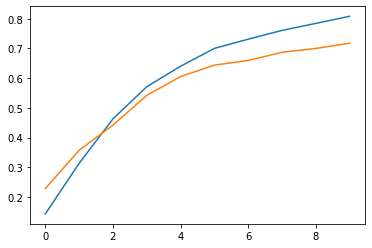

57/57 [==============================] - 2s 30ms/step - loss: 0.1657 - accuracy: 0.7161


In [11]:
### Normal stacked LSTMs ###
model1 = keras.Sequential()
model1.add(layers.LSTM(25,return_sequences=True, input_shape=(m,n)))
model1.add(layers.LSTM(32))
model1.add(layers.Dense(10, activation='sigmoid'))



### Run the model ###
compile_fit_eval(model1, X_train, y_train, X_val, y_val, X_test, y_test,"key")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 150, 64)          24832     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 92,170
Trainable params: 92,170
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
271/271 [==============================] - 96s 302ms/step - loss: 0.3000 - accuracy: 0.3656 - val_loss: 0.2237 - val_accuracy: 0.6203
Epoch 2/10
271/271 [=================

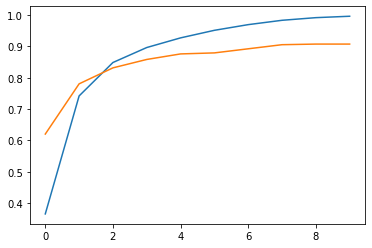

57/57 [==============================] - 4s 71ms/step - loss: 0.0614 - accuracy: 0.9133


In [12]:
### Bi-directional stacked LSTMs ###
model2 = keras.Sequential()
model2.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True), input_shape=(m,n)))
model2.add(layers.Bidirectional(layers.LSTM(64)))
model2.add(layers.Dense(10, activation='sigmoid'))

##### END OF TODO #####

compile_fit_eval(model2, X_train, y_train, X_val, y_val, X_test, y_test,"key")

In [13]:
### CNN LSTM model ###

### Reshape Everything ###
seqSize = X_train.shape[1]
nbFeatures = 64
nbSubSeq = 5
subSeqSize = int(seqSize / nbSubSeq) 

##### TODO #####
X_train2 = X_train.reshape(-1, nbSubSeq, subSeqSize, nbFeatures)
X_val2 = X_val.reshape(-1, nbSubSeq, subSeqSize, nbFeatures)
X_test2 = X_test.reshape(-1, nbSubSeq, subSeqSize, nbFeatures)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDis  (8670, 5, 28, 32)        6176      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (8670, 5, 896)           0         
 tributed)                                                       
                                                                 
 lstm_5 (LSTM)               (8670, 25)                92200     
                                                                 
 dense_3 (Dense)             (8670, 10)                260       
                                                                 
Total params: 98,636
Trainable params: 98,636
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
271/271 [==============================

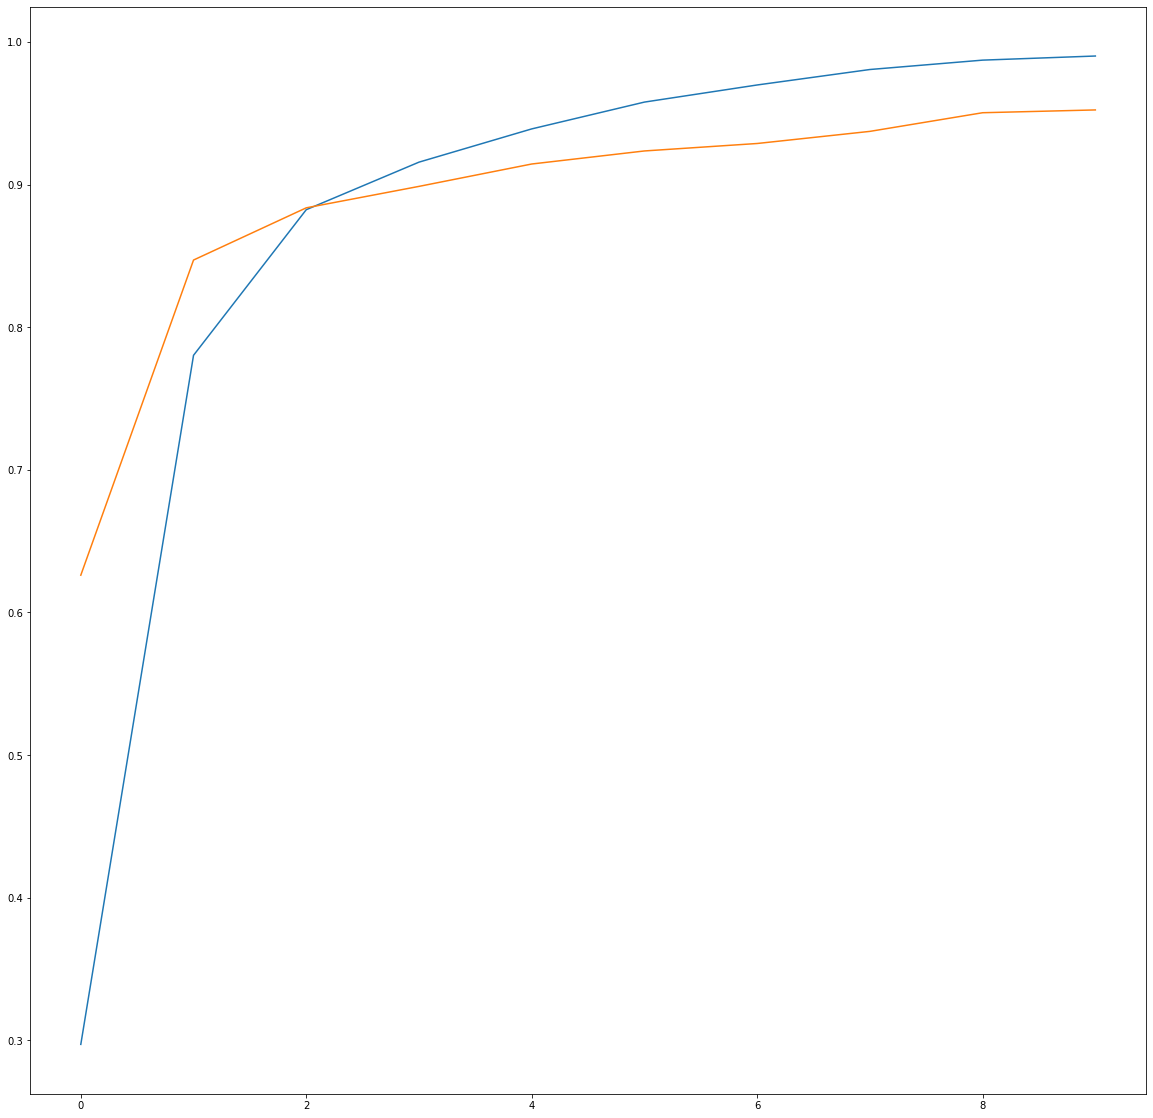

57/57 [==============================] - 1s 12ms/step - loss: 0.0527 - accuracy: 0.9422


In [19]:
### CNN LSTM Model define ###
modelCL = keras.Sequential()
modelCL.add(layers.TimeDistributed(layers.Conv1D(32, 3, activation='relu',input_shape=( nbSubSeq, subSeqSize, nbFeatures)   )))
modelCL.add(layers.TimeDistributed(layers.Flatten()))
modelCL.add(layers.LSTM(25))
modelCL.add(layers.Dense(10, activation='sigmoid'))



##### END OF TODO #####

compile_fit_eval(modelCL, X_train2, y_train, X_val2, y_val, X_test2, y_test, key="CL")

In [23]:
# plot the confusion matrix

import os
import itertools
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
from typing import Dict, List


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues) -> None:

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.rcParams["figure.figsize"] = (20, 20)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, range(len(classes)), rotation=45)
    plt.yticks(tick_marks, range(len(classes)))

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [24]:
### Function to encode back to categorical data ###

def encode(y):
  y_enc = []
  for arr in y:
    cl = np.argmax(arr)
    y_enc.append(cl)
  y_enc = np.array(y_enc)
  return y_enc
    

In [25]:
### Convert the one hot encoded into categorical values ###
y_pred = modelCL.predict(X_test2)
y_test_enc = encode(y_test)
y_pred_enc = encode(y_pred)
classes = np.arange(0,10)
cm = sklearn.metrics.confusion_matrix(y_test_enc, y_pred_enc)

57/57 [==============================] - 1s 10ms/step


Confusion matrix, without normalization


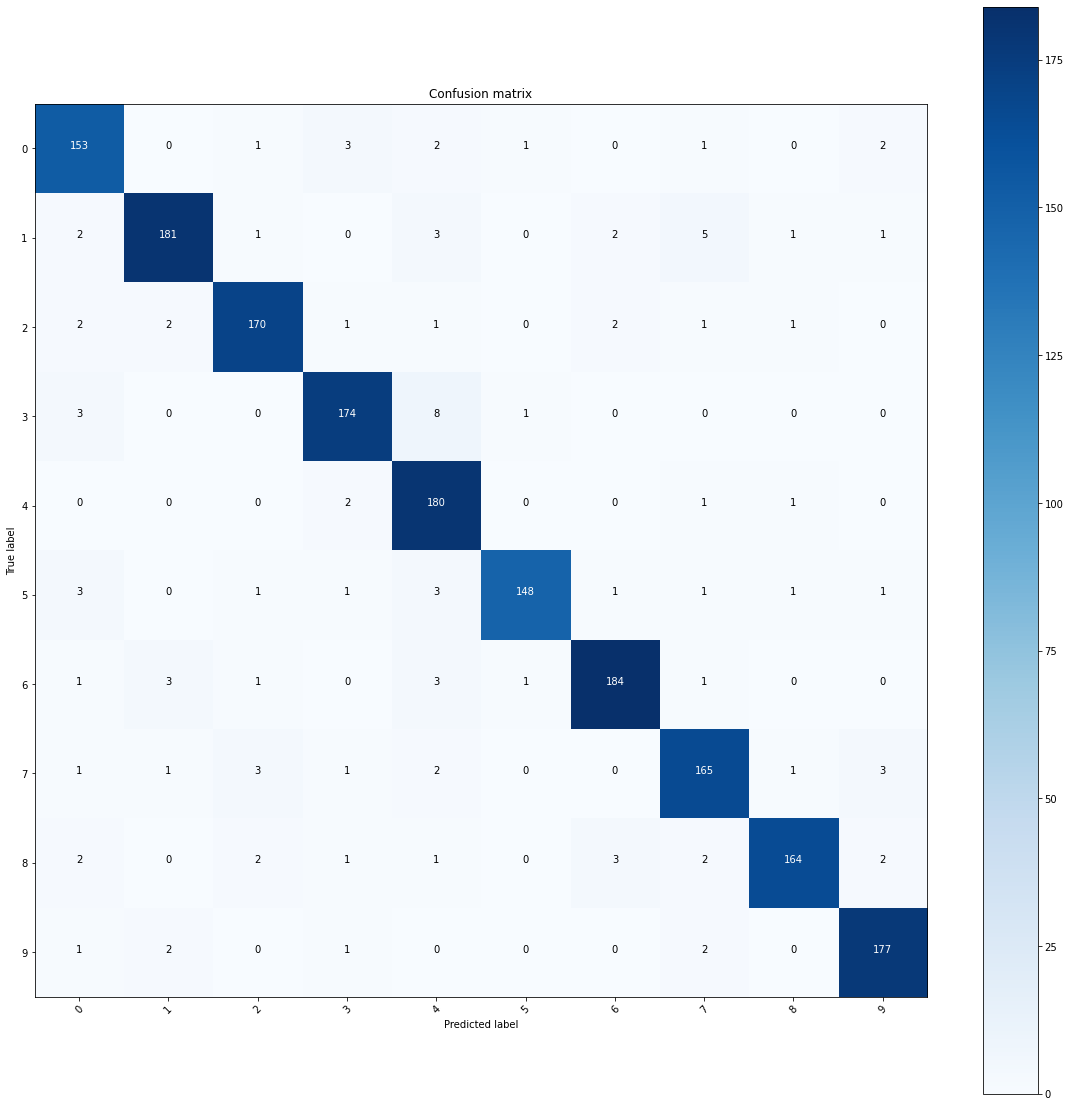

In [26]:
### Display the confusion matrix ###
plot_confusion_matrix(cm, classes)